In [110]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [128]:
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_test = pd.read_pickle("./data_frames/df_test.pkl")
df_dp_train = pd.read_pickle("./data_frames/dependency_parsing/df_dp_train.pkl")
df_dp_test = pd.read_pickle("./data_frames/dependency_parsing/df_dp_test.pkl")
df_dp_train.head()

,answer,answer_words,answer_pos,answer_deprel,answer_root,answer_root_pos,sent_with_ans,sent_words,sent_pos,sent_deprel,sent_root,sent_root_pos,question,q_words,q_pos,q_deprel,q_root,q_root_pos,answer_root_word,sent_root_word,q_root_word
0,ett tillstånd för att resa in och vara i ett land,"[en, tillstånd, för, att, resa, in, och, vara,...","[DET, NOUN, ADP, PART, VERB, ADV, CCONJ, AUX, ...","[det, root, mark, mark, advcl, compound:prt, c...",tillstånd,NOUN,visum är ett tillstånd för att resa in och var...,"[visum, vara, en, tillstånd, för, att, resa, i...","[NOUN, AUX, DET, NOUN, ADP, PART, VERB, ADV, C...","[nsubj, cop, det, root, mark, mark, advcl, com...",tillstånd,NOUN,vad är ett visum,"[vad, vara, en, visum]","[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,tillstånd,tillstånd,vad
1,ditt pass,"[du, pass]","[PRON, NOUN]","[nmod:poss, root]",pass,NOUN,när du ska hämta ditt beslut ska du ta med dit...,"[när, du, skola, hämta, du, beslut, skola, du,...","[SCONJ, PRON, AUX, VERB, PRON, NOUN, AUX, PRON...","[mark, nsubj, aux, advcl, nmod:poss, obj, aux,...",ta,VERB,vad ska du ta med när du hämtar ditt beslut,"[vad, skola, du, ta, med, när, du, hämta, du, ...","[PRON, AUX, PRON, VERB, ADP, SCONJ, PRON, VERB...","[obj, aux, nsubj, root, compound:prt, mark, ns...",ta,VERB,pass,ta,ta
2,ett år,"[en, år]","[DET, NOUN]","[det, root]",år,NOUN,ett uppehållstillstånd för besök gäller som lä...,"[en, uppehållstillstånd, för, besök, gälla, so...","[DET, NOUN, ADP, NOUN, VERB, SCONJ, ADV, ADV, ...","[det, nsubj, case, nmod, root, advmod, advmod,...",gälla,VERB,hur länge gäller ett uppehållstillstånd för be...,"[hur, länge, gälla, en, uppehållstillstånd, fö...","[ADV, ADV, VERB, DET, NOUN, ADP, NOUN, CCONJ, ...","[advmod, advmod, root, det, nsubj, case, nmod,...",gälla,VERB,år,gäller,gäller
3,ett bevis,"[en, bevis]","[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,"[kort, vara, en, bevis, på, att, du, ha, tills...","[NOUN, AUX, DET, NOUN, ADP, SCONJ, PRON, VERB,...","[nsubj, cop, det, root, mark, mark, nsubj, adv...",bevis,NOUN,vad är ett uppehållstillståndskort,"[vad, vara, en, uppehållstillståndskort]","[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,bevis,bevis,vad
4,ett bevis,"[en, bevis]","[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,"[kort, vara, en, bevis, på, att, du, ha, tills...","[NOUN, AUX, DET, NOUN, ADP, SCONJ, PRON, VERB,...","[nsubj, cop, det, root, mark, mark, nsubj, adv...",bevis,NOUN,vad är ett uppehållstillståndskort,"[vad, vara, en, uppehållstillståndskort]","[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,bevis,bevis,vad


In [129]:
def plot_normalized_overlap(df, title, bins, type):
    o_len = df[type+'_overlap_count'].values
    max_len = np.minimum(df[type+'_ans_wordcount'].values, df[type+'_q_wordcount'].values)
    frac_len = o_len/max_len
    # print('frac_len: ', frac_len)
    mean = np.nanmean(frac_len)
    print('mean: ', mean)
    # flat_list = [item for sublist in locations for item in sublist]
    plt.hist(frac_len, density=True, bins=bins)
    plt.axvline(mean, color='g', linestyle='dashed', linewidth=1, label='mean: {:.2f}'.format(mean))
    plt.ylabel('Vol')
    plt.xlabel('Fraction of words overlapping')
    plt.legend()
    plt.title(title)
    plt.show()

In [130]:
def find_overlap_sent(a_w, q_w):
    overlap = 0
    overlap_w = []
    for w in a_w:
        if w in q_w:
            overlap += 1
            overlap_w.append(w)
    return overlap, overlap_w


# find the number of overlapping words between sent_with_ans / question / correct_answer
def find_word_overlap_base(df):
    overlap_nr = []
    overlap_words = []
    tot_ans_words_arr = []
    tot_q_words_arr = []
    for index, row in df.iterrows():
        q = row['question'].lower()
        a = row['sent_with_ans'].lower()
        a = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', a)
        q = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', q)
        # split in to words
        q_w = word_tokenize(q)
        a_w = word_tokenize(a)
        q_w = list(dict.fromkeys(q_w)) # remove duplicate words
        a_w = list(dict.fromkeys(a_w)) # remove duplicate words

        tot_ans_words_arr.append(len(a_w))
        tot_q_words_arr.append(len(q_w))
        overlap, overlap_w = find_overlap_sent(a_w, q_w)
        
        overlap_words.append(overlap_w)
        overlap_nr.append(overlap)
    
    return overlap_nr, overlap_words, tot_ans_words_arr, tot_q_words_arr

df_dp_train['base_overlap_count'], df_dp_train['base_overlap_words'], df_dp_train['base_ans_wordcount'], df_dp_train['base_q_wordcount'] = find_word_overlap_base(df_train)
df_dp_test['base_overlap_count'], df_dp_test['base_overlap_words'], df_dp_test['base_ans_wordcount'], df_dp_test['base_q_wordcount'] = find_word_overlap_base(df_test)


In [131]:
# Removing stopwords from array of words
def remove_stopwords_sentence(sentence):
    stop_words = set(stopwords.words('swedish'))
    filtered_sentence = [w for w in sentence if not w.lower() in stop_words]
    return filtered_sentence

In [133]:
# find overlap using the lemmatized versions of the answer sentences and questions
def find_word_overlap_lemmatized(df, remove_stopwords=False):
    overlap_nr = []
    overlap_words = []
    tot_ans_words_arr = []
    tot_q_words_arr = []
    for index, row in df.iterrows():
        q_w = row['q_words']
        a_w = row['sent_words']
        q_w = list(dict.fromkeys(q_w)) # remove duplicate words
        a_w = list(dict.fromkeys(a_w)) # remove duplicate words
        if remove_stopwords:
            q_w = remove_stopwords_sentence(q_w)
            a_w = remove_stopwords_sentence(a_w)
        tot_ans_words_arr.append(len(a_w))
        tot_q_words_arr.append(len(q_w))
        overlap, overlap_w = find_overlap_sent(a_w, q_w)
        
        overlap_words.append(overlap_w)
        overlap_nr.append(overlap)
    
    return overlap_nr, overlap_words, tot_ans_words_arr, tot_q_words_arr

df_dp_train['lemma_overlap_count'], df_dp_train['lemma_overlap_words'], df_dp_train['lemma_ans_wordcount'], df_dp_train['lemma_q_wordcount'] = find_word_overlap_lemmatized(df_dp_train)
df_dp_test['lemma_overlap_count'], df_dp_test['lemma_overlap_words'], df_dp_test['lemma_ans_wordcount'], df_dp_test['lemma_q_wordcount'] = find_word_overlap_lemmatized(df_dp_test)

# stats when removing stopwords
df_dp_train['stop_lemma_overlap_count'], df_dp_train['stop_lemma_overlap_words'], df_dp_train['stop_lemma_ans_wordcount'], df_dp_train['stop_lemma_q_wordcount'] = find_word_overlap_lemmatized(df_dp_train, True)
df_dp_test['stop_lemma_overlap_count'], df_dp_test['stop_lemma_overlap_words'], df_dp_test['stop_lemma_ans_wordcount'], df_dp_test['stop_lemma_q_wordcount'] = find_word_overlap_lemmatized(df_dp_test, True)


mean:  0.5630919543502897


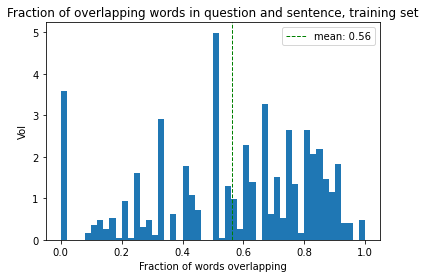

mean:  0.6135334346100108


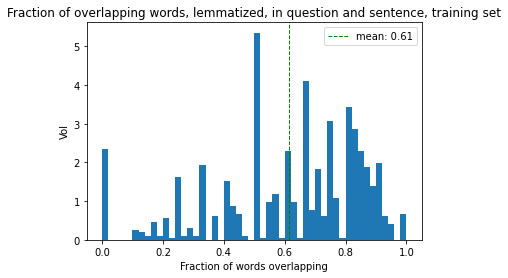

mean:  0.7096962981578366


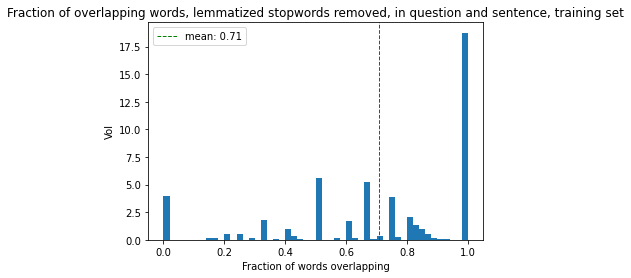

mean:  0.5579030541306756


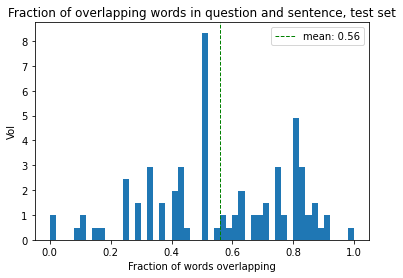

mean:  0.6092286892798402


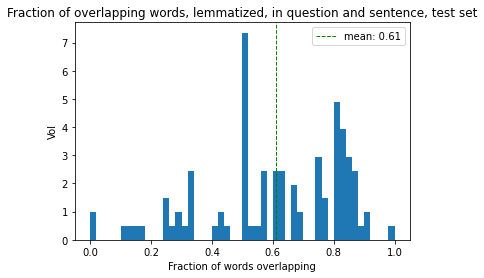

mean:  0.7063955380131848


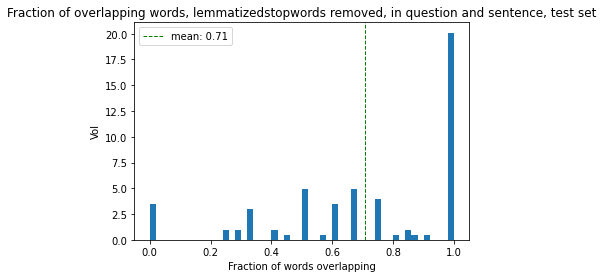

In [134]:
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping words in question and sentence, training set', 50, 'base')
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping words, lemmatized, in question and sentence, training set', 50, 'lemma')
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping words, lemmatized stopwords removed, in question and sentence, training set', 50, 'stop_lemma')
plot_normalized_overlap(df_dp_test, 'Fraction of overlapping words in question and sentence, test set', 50, 'base')
plot_normalized_overlap(df_dp_test, 'Fraction of overlapping words, lemmatized, in question and sentence, test set', 50, 'lemma')
plot_normalized_overlap(df_dp_test, 'Fraction of overlapping words, lemmatizedstopwords removed, in question and sentence, test set', 50, 'stop_lemma')

In [137]:
# find the question answer pairs where there is no / little overlap in words
def print_overlap(filename, df, type):
    with open(filename, 'w') as out:
        for index, row in df.iterrows():
            out.write('-------------------'+ '\n')
            out.write('overlapping words: ' + ' '.join(row[type+'_overlap_words']) + '\n')
            out.write('question: ' + row['question'] + '\n')
            out.write('answer: ' + row['answer'] + '\n')
            out.write('sentence with answer: '+ row['sent_with_ans']+ '\n')



df_train_little_overlap_base = df_dp_train.loc[df_dp_train['base_overlap_count'] < 2]
print('Number of Q/A pairs that have no word overlap: ', len(df_train_little_overlap_base)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-base.txt', df_train_little_overlap_base, 'base')

df_train_little_overlap = df_dp_train.loc[df_dp_train['lemma_overlap_count'] < 2]
print('Number of lemmatized Q/A pairs that have no word overlap: ', len(df_train_little_overlap)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-lemma.txt', df_train_little_overlap, 'lemma')

df_train_little_overlap_stop = df_dp_train.loc[df_dp_train['stop_lemma_overlap_count'] < 2]
print('Number of lemmatized Q/A pairs with stopwords removed that have no word overlap: ', len(df_train_little_overlap_stop)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-stopwords-lemma.txt', df_train_little_overlap_stop, 'stop_lemma')

Number of Q/A pairs that have no word overlap:  0.16632016632016633
Number of lemmatized Q/A pairs that have no word overlap:  0.11746361746361747
Number of lemmatized Q/A pairs with stopwords removed that have no word overlap:  0.2151767151767152
